In [169]:
#!pip install csv
#!pip install wordcloud
#!pip install tweepy
#!pip install nltk
#nltk.download('punkt')
#nltk.download('stopwords')


#!pip install textblob
#!pip install pyspark
#!pip install sagemaker_pyspark

In [149]:
import os
import pandas as pd
import datetime

import nltk
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
stop_words = set(stopwords.words("portuguese"))
from nltk.probability import FreqDist

from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField,StringType, FloatType, DateType, LongType, NumericType
from pyspark import SparkContext, SparkConf
from pyspark.sql.functions import create_map, struct

import re

from textblob import TextBlob

from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

In [150]:
indice_repositorio = '../repositorio/indice_repositorios.csv'

In [151]:
#classpath = ":".join(sagemaker_pyspark.classpath_jars())

builder = SparkSession.builder.appName("AnaliseTwitter")
builder.config("spark.hadoop.mapreduce.fileoutputcommitter.algorithm.version", "2")
builder.config("spark.speculation", "false")
builder.config("spark.sql.parquet.compression.codec", "gzip")
builder.config("spark.debug.maxToStringFields", "100")
#builder.config("spark.driver.extraClassPath", classpath)
builder.config("spark.driver.memory", "1g")
builder.config("spark.driver.cores", "1")
builder.config("spark.executor-memory", "20g")
builder.config("spark.executor.cores", "4")

builder.master("local[*]")

spark = builder.getOrCreate()
spark

In [152]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(spark.sparkContext)

df = sqlContext.read.format('com.databricks.spark.csv')\
.options(header='true', delimiter=';', inferschema='false')\
.load(indice_repositorio)\
.toDF("Tipo","Caminho","Filtro","Descrição","data_criacao","criado_por","email_crador")\
.orderBy('path',ascending=False)\
.select("Tipo","Caminho","Filtro","Descrição","data_criacao")
df.show(truncate=False)


+-------+----------------------------------------------------------------------------+------------------------------------+------------------------------------------------------------------------------------------------------------+------------+
|Tipo   |Caminho                                                                     |Filtro                              |Descrição                                                                                                   |data_criacao|
+-------+----------------------------------------------------------------------------+------------------------------------+------------------------------------------------------------------------------------------------------------+------------+
|Twitter|/home/jovyan/volume/repositorio/twittes/copa_or_confederação                |copa OR confederação                |Repositorio de dados dos tweets captados diariamente, a partir do filtro de busca definido na coluna filtro.|2019-07-09  |
|Twitter|/home/j

In [153]:
url_repositorio = '/home/jovyan/volume/repositorio/twittes/copa_or_confederação'

In [154]:
lista_de_arquivos = []
def listar_pasta(pasta):
    tot = 0
    subpastas = list()
    if os.path.isdir(pasta):
        items = os.listdir(pasta)
        for item in items:
            novo_item = os.path.join(pasta,item)
            if os.path.isdir(novo_item):
                subpastas.append(novo_item)
                if (novo_item.find('.ipynb_checkpoints') < 0):
                    lista_de_arquivos.append(novo_item+'/*.csv')
                continue

        for subpasta in subpastas:
            listar_pasta(subpasta)

    return lista_de_arquivos


todos_os_diretorios = listar_pasta(url_repositorio)
print('Tweets dos últimos {} dias'.format(len(todos_os_diretorios) ))

Tweets dos últimos 1 dias


In [155]:
sql = []
qtd = 0

for item in range(len(todos_os_diretorios)):
    
    df_temp = sqlContext.read.format('com.databricks.spark.csv')\
    .options(header='false', delimiter=';', inferschema='false')\
    .load(todos_os_diretorios[item])\
    .toDF('id_tweet','data_tweet','id_usuario','nome_usuario','nome_conta','foto_usuario','qtd_amigos','texto_tweet','texto_tweet_tratado','analise_sentimento','localizacao')
    qtd += df_temp.count()
    
    df_temp.registerTempTable("tmp_table"+str(item))
    sql.append("select distinct * from tmp_table"+str(item)+" ")

sql_= ' union '.join(sql)  
sqlDF = sqlContext.sql(sql_+ 'order by nome_usuario')    
sqlDF.select()


sqlDF.registerTempTable("tbl_todos_registro")


print('Total de tweets {}'.format(qtd))
texto_tweets=''
for f in sqlDF.collect(): 
    texto_tweets=texto_tweets+str(f.texto_tweet_tratado)
        
tokens_texto_tweets = nltk.word_tokenize(texto_tweets)

Total de tweets 500


In [192]:
#Extrai a quantidade de tweets por região
sqlDfDet = sqlContext.sql("select count(*) as qtd, localizacao from \
                          tbl_todos_registro \
                          where localizacao <> 'null' \
                          group by localizacao\
                          order by qtd desc, localizacao")\
.select('qtd','localizacao')\
.filter('qtd >=10')\
.select('qtd','localizacao')

sqlDfDet.registerTempTable("tbl_qtd_localizacao")

sqlDfDet.show(qtd, truncate=False)


+---+----------------------+
|qtd|localizacao           |
+---+----------------------+
|24 |São Paulo, Brasil     |
|22 |Brasil                |
|21 |Rio de Janeiro, Brasil|
|12 |Rio de Janeiro        |
+---+----------------------+



Text(0.5, 0.98, 'Quantidade de tweets por localidade')

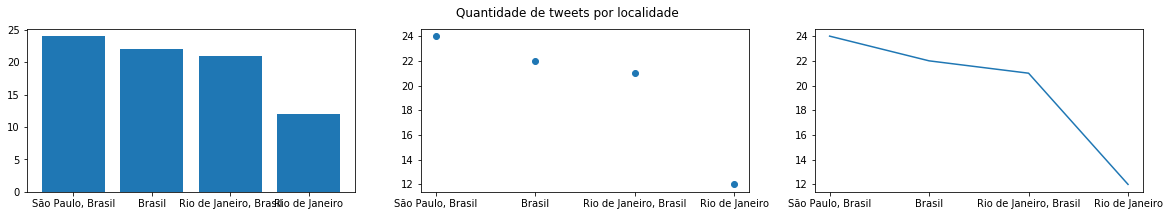

In [198]:
dados = {}
for f in sqlDfDet.collect(): 
    dados.update({f.localizacao:f.qtd} )

names = list(dados.keys())
values = list(dados.values())

fig, axs = plt.subplots(1, 3, figsize=(20, 3), sharey=False)
axs[0].bar(names, values)
axs[1].scatter(names, values)
axs[2].plot(names, values)
fig.suptitle('Quantidade de tweets por localidade')

In [199]:
#Extrai a quantidade de tweets por usuário
sqlDfDet = sqlContext.sql('select count(*) as qtd, nome_conta from \
                          tbl_todos_registro group by nome_conta\
                          order by qtd desc, nome_conta')\
.select('qtd','nome_conta')\
.filter('qtd >=3')\
.show(qtd, truncate=False)


+---+--------------+
|qtd|nome_conta    |
+---+--------------+
|4  |agoranomundobr|
|4  |olucass9      |
|3  |AlvinegroFera |
|3  |PaulaShak     |
|3  |josiel_borges |
|3  |renatorosaec  |
+---+--------------+



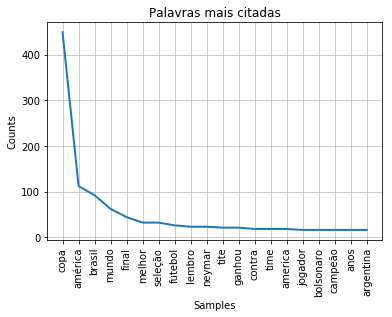

In [146]:
#Monta o gráfico com as 20 palavras mais citadas no texto********#
fdist = FreqDist(tokens_texto_tweets)
fdist.most_common(20)
plt.figure()
fdist.plot(20,cumulative=False, title='Palavras mais citadas') 
plt.show()
#****************************************************************#

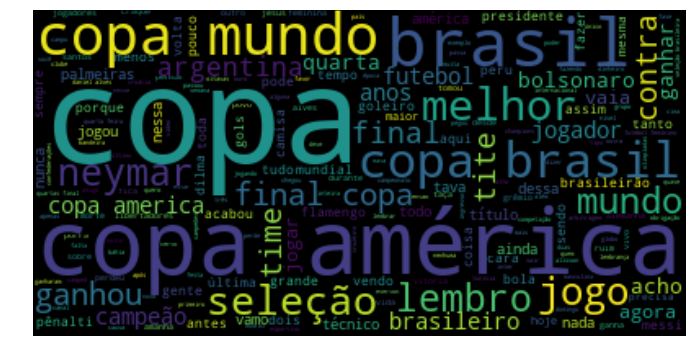

In [147]:
#Monta o wordcloud com as palavras mais citadas no texto*********#
wordcloud = WordCloud().generate(texto_tweets)
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
#****************************************************************#